In [1]:
import tensorflow as tf
import argparse
import time
import os
import numpy as np
from six.moves import cPickle
from evaluator import Evaluator
from utils import textloader
from model import Model
import pickle

In [2]:
#Read text input
batch_size = 1
data_loader = textloader('/home/wanli/data/glove.6B/',batch_size)
vocab_size = data_loader.vocab_size

if os.path.exists('abstracrs_word_embeddings_dummy.pkl'):
    print('Loading abstracts')
    with open('abstracrs_word_embeddings_dummy.pkl', 'rb') as f:
        data_loader.all_documents= pickle.load(f)

Loading embeddings  /home/wanli/data/glove.6B/glove.6B.200d.txt
Loading abstracts


In [3]:
print('Loading ratings')
ratings_path = '/home/wanli/data/Extended_ctr/dummy/users.dat'
data_loader.read_dataset(ratings_path,50,1928)#CHANGE ++++++++

Loading ratings


23
8810
57


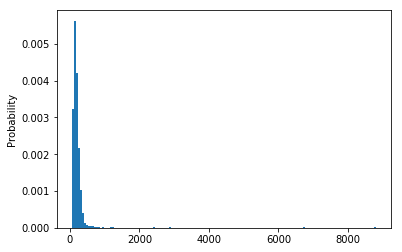

In [5]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
x = np.random.normal(size = 1000)
lengths = []
long_docs=0
for d in data_loader.all_documents.values():
    # if len(d) < 400:
    lengths.append(len(d))
    if len(d) < 75:
        long_docs += 1
print(long_docs)
print(max(lengths))
print(min(lengths))
plt.hist(lengths, normed=True, bins=150)
plt.ylabel('Probability');

In [4]:
bucket_boundaries = [x for x in range (75,450,50)]
print(bucket_boundaries)

[75, 125, 175, 225, 275, 325, 375, 425]


In [6]:
n_steps=1
training = []
label = []
for u, v, r, d, step in data_loader.generate_batches(n_steps):
    training.append((u,v,d,len(d)))
label=np.ones(len(training))

In [7]:
print(len(training))
print(len(label))

1866
1866


In [17]:
# lengths = tf.placeholder(tf.int32, ())
batch_size = 128

batch_s = batch_size

input_text = tf.placeholder(tf.int32, [batch_s,None],name="Input_text")
seq_lengths = tf.placeholder(tf.int32, [batch_s])
u_idx = tf.placeholder(tf.int32, [batch_s],name="U_matrix")
v_idx = tf.placeholder(tf.int32, [batch_s],name="V_matrix")
r = tf.placeholder(tf.float32, [batch_s],name="R_target")

input_queue = tf.FIFOQueue(
      5000, (tf.int32,tf.int32, tf.int32, tf.int32,tf.float32),shapes=([batch_s,30],[batch_s],[batch_s],[batch_s],[batch_s]))
input_enqueue_op = input_queue.enqueue((input_text, seq_lengths, u_idx,v_idx,r))
input_t, lengths_t, u_idx_t, v_idx_t, r_t = input_queue.dequeue()
close_input_op = input_queue.close()



seq_len, outputs = tf.contrib.training.bucket_by_sequence_length(
    128,tensors=[input_t, lengths_t, u_idx_t, v_idx_t, r_t],allow_smaller_final_batch=True,\
                                                                     batch_size=batch_size,bucket_boundaries=bucket_boundaries, \
                                                                     capacity= 2 * batch_size,dynamic_pad= True)
expected_batch_size =  batch_s
assertEqual(out_lengths_t.get_shape().as_list(),
                 [expected_batch_size])
assertEqual(data_and_labels_t[0].get_shape().as_list(),
                 [expected_batch_size, data_len])
assertEqual(data_and_labels_t[1].get_shape().as_list(),
                 [expected_batch_size, labels_len])

NameError: name 'assertEqual' is not defined

In [27]:
batch_size = 128
lengths = []
for d in data_loader.all_documents.values():
        lengths.append(len(d))
print(len(lengths))
# with tf.name_scope("batch_examples"):
#     seq_len, outputs = tf.contrib.training.bucket_by_sequence_length(lengths,data_loader.all_documents,batch_size,bucket_boundaries, \
#                                                                      capacity= 2 * batch_size,dynamic_pad= True)

1929


In [18]:
sess = tf.Session()

sess.run(tf.global_variables_initializer())

In [21]:
s, o = sess.run([seq_len,outputs])

In [17]:
batch_size = 128

input_text = tf.placeholder(tf.int32, [batch_size,None],name="Input_text")
seq_lengths = tf.placeholder(tf.int32, [batch_size])
u_idx = tf.placeholder(tf.int32, [None],name="U_matrix")
v_idx = tf.placeholder(tf.int32, [None],name="V_matrix")
r = tf.placeholder(tf.float32, [None],name="R_target")

in_shape =input_text.get_shape().as_list()

input_queue = tf.FIFOQueue(
          5000, (tf.int32,tf.int32, tf.int32, tf.int32,tf.float32),shapes=[[batch_size,None], (batch_size), (),(),()])

ValueError: All shapes must be fully defined: [TensorShape([Dimension(128), Dimension(None)]), TensorShape([Dimension(128)]), TensorShape([]), TensorShape([]), TensorShape([])]

In [14]:
print(input_queue.shapes)

[TensorShape([Dimension(128)]), TensorShape([Dimension(128)]), TensorShape([]), TensorShape([]), TensorShape([])]


In [15]:
input_enqueue_op = input_queue.enqueue((input_text, seq_lengths, u_idx,v_idx,r))
input_t, lengths_t, u_idx_t, v_idx_t, r_t = input_queue.dequeue()
close_input_op = input_queue.close()

ValueError: Shapes (128, ?) and (128,) are incompatible

In [26]:
print(lengths_t.get_shape())

<unknown>


In [5]:
import numpy as np
import tensorflow as tf


class SequenceTable:
    def __init__(self, data):
        # A TensorArray is required as the sequences don't have the same
        # length. Alternatively a FIFOQueue can be used.
        # Because the data is read more than once by the queue,
        # clear_after_read is set to False (but I can't confirm an effect).
        # Because the items has diffrent sequence lengths the infer_shape
        # is set to False. The shape is then restored in the .read method.
        self.table = tf.TensorArray(size=len(data),
                                    dtype=data[0].dtype,
                                    dynamic_size=False,
                                    clear_after_read=False,
                                    infer_shape=False)

        # initialize table
        for i, datum in enumerate(data):
            self.table = self.table.write(i, datum)

        # setup infered element shape
        self.element_shape = tf.TensorShape((None, ) + data[0].shape[1:])

    def read(self, index):
        # read index from table and set infered shape
        read = self.table.read(index)
        read.set_shape(self.element_shape)
        return read


def shuffle_bucket_batch(input_length, tensors, shuffle=True, **kwargs):
    # bucket_by_sequence_length requires the input_length and tensors
    # arguments to be queues. Use a range_input_producer queue to shuffle
    # an index for sliceing the input_length and tensors laters.
    # This strategy is idendical to the one used in slice_input_producer.
    table_index = tf.train.range_input_producer(
        int(input_length.get_shape()[0]), shuffle=shuffle
    ).dequeue()

    # the first argument is the sequence length specifed in the input_length
    # I did not find a ue for it.
    _, batch_tensors = tf.contrib.training.bucket_by_sequence_length(
        input_length=tf.gather(input_length, table_index),
        tensors=[tensor.read(table_index) for tensor in tensors],
        **kwargs
    )

    return tuple(batch_tensors)


# these values specify the length of the sequence and this controls how
# the data is bucketed. The value is not required to be the acutal length,
# which is also problematic when using pairs of sequences that have diffrent
# length. In that case just specify a value that gives the best performance,
# for example "the max length".
length_table = tf.constant([2, 4, 3, 4, 3, 7], dtype=tf.int32)

source_table = SequenceTable([
    np.asarray([3, 4], dtype=np.int32),
    np.asarray([2, 3, 4], dtype=np.int32),
    np.asarray([1, 3, 4], dtype=np.int32),
    np.asarray([5, 3, 4], dtype=np.int32),
    np.asarray([6, 3, 4], dtype=np.int32),
    np.asarray([3, 3, 3, 3, 3, 3], dtype=np.int32)
])

target_table = SequenceTable([
    np.asarray([9], dtype=np.int32),
    np.asarray([9, 3, 4, 5], dtype=np.int32),
    np.asarray([9, 3, 4], dtype=np.int32),
    np.asarray([9, 3, 4, 6], dtype=np.int32),
    np.asarray([9, 3], dtype=np.int32),
    np.asarray([9, 3, 3, 3, 3, 3, 2], dtype=np.int32)
])

source_batch, target_batch = shuffle_bucket_batch(
    length_table, [source_table, target_table],
    batch_size=2,
    # devices buckets into [len < 3, 3 <= len < 5, 5 <= len]
    bucket_boundaries=[3, 5],
    # this will bad the source_batch and target_batch independently
    dynamic_pad=True,
    capacity=2
)

with tf.Session() as sess:
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess, coord)

    for i in range(6):
        source, target = sess.run((source_batch, target_batch))
        print('source_output [{0}]'.format(i))
        print(source)
        print('target_output [{0}]'.format(i))
        print(target)
        print('')

    coord.request_stop()
    coord.join(threads)

source_output [0]
[[5 3 4]
 [1 3 4]]
target_output [0]
[[9 3 4 6]
 [9 3 4 0]]

source_output [1]
[[2 3 4]
 [6 3 4]]
target_output [1]
[[9 3 4 5]
 [9 3 0 0]]

source_output [2]
[[3 4]
 [3 4]]
target_output [2]
[[9]
 [9]]

source_output [3]
[[2 3 4]
 [6 3 4]]
target_output [3]
[[9 3 4 5]
 [9 3 0 0]]

source_output [4]
[[5 3 4]
 [1 3 4]]
target_output [4]
[[9 3 4 6]
 [9 3 4 0]]

source_output [5]
[[3 3 3 3 3 3]
 [3 3 3 3 3 3]]
target_output [5]
[[9 3 3 3 3 3 2]
 [9 3 3 3 3 3 2]]



In [31]:
import tensorflow as tf
def num_samples(path):
    c = 0
    for record in tf.python_io.tf_record_iterator(path):
        example_proto = tf.train.SequenceExample()
        example_proto.ParseFromString(record)
        c += 1
    return c

def _parse_function(sequence_example_proto):
        context_feature = {'u': tf.FixedLenFeature([], tf.int64),
                           'v': tf.FixedLenFeature([], tf.int64),
                           'r': tf.FixedLenFeature([], tf.int64),
                           'abs_length': tf.FixedLenFeature([], tf.int64)}

        sequence_feature = {'abstract': tf.FixedLenSequenceFeature([], tf.int64)}

        # Decode the record read by the reader
        context_feature, sequence_feature = tf.parse_single_sequence_example(sequence_example_proto,
                                                                             context_features=context_feature,
                                                                             sequence_features=sequence_feature)
        u = tf.cast(context_feature['u'], tf.int32)
        v = tf.cast(context_feature['v'], tf.int32)
        r = tf.cast(context_feature['r'], tf.int32)
        abs_length = tf.cast(context_feature['abs_length'], tf.int32)
        abstract = tf.cast(sequence_feature['abstract'], tf.int32)
        return u, v, r, abstract, abs_length
def input(batch_size):
    filename ='/home/wanli/data/Extended_ctr/dummy_test_0.tfrecords'
    print ('number of samples {0}'.format(num_samples(filename)))
    dataset = tf.contrib.data.TFRecordDataset(filename)
    
    # Repeat the input indefinitely.
    dataset = dataset.repeat()
    # Parse the record into tensors.
    dataset = dataset.map(_parse_function)
    # Shuffle the dataset
    dataset = dataset.shuffle(buffer_size=10000)
    # Generate batches
    # dataset = dataset.batch(128)
    
    # iterator = dataset.make_initializable_iterator()
    # print(dataset.output_types)  # ==> (tf.float32, (tf.float32, tf.int32))
    # print(dataset.output_shapes)  # ==> "(10, ((), (100,)))"
    
    dataset = dataset.padded_batch(128, padded_shapes=((), (), (), [None], ()))
    # Create a one-shot iterator
    iterator = dataset.make_one_shot_iterator()
    next_element = iterator.get_next()
    return next_element 
# with tf.Session() as sess:
#     for i in range(100):
#         record = sess.run(next_element)
batch_size = 85
next_element = input(batch_size)
pairs = {}
with tf.Session() as sess:
    for i in range(1):
        record = sess.run(next_element)
        for j in range(batch_size):
            print(record[0][j],record[1][j])
            for i in range

number of samples 85


48 1208
20 872
26 947
37 46
13 710
12 647
39 832
20 258
20 295
12 1171
37 467
39 832
21 876
20 872
13 710
20 528
21 751
20 258
44 375
49 537
10 416
20 883
20 885
21 751
20 872
37 46
46 111
20 844
26 947
21 751
21 666
20 258
21 881
20 751
12 1171
49 657
20 181
21 751
20 295
4 804
4 804
47 277
21 514
21 881
47 277
21 666
39 836
21 737
49 1310
20 751
20 181
20 181
20 827
20 827
12 41
20 844
20 837
21 876
20 844
44 375
13 63
46 1597
21 666
46 111
49 1310
23 110
37 467
11 62
4 804
10 416
10 56
22 822
23 110
13 63
39 832
47 277
43 232
21 881
23 1208
49 355
49 1310
21 751
20 872
43 232
49 355
